In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima




In [2]:
df=pd.read_csv('Erathna_project.csv')
df.head()





,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,130.2,22.1,32.1,NaN,NaN
1,2010,February,41.3,22.6,33.9,NaN,NaN
2,2010,March,171.5,23.1,35.2,NaN,NaN
3,2010,April,421.7,23.7,33.5,NaN,NaN
4,2010,May,793.3,24.0,31.8,NaN,NaN


In [3]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)


In [4]:
df.head()


,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,130.2,22.1,32.1,NaN,NaN,2010-January
1,2010,February,41.3,22.6,33.9,NaN,NaN,2010-February
2,2010,March,171.5,23.1,35.2,NaN,NaN,2010-March
3,2010,April,421.7,23.7,33.5,NaN,NaN,2010-April
4,2010,May,793.3,24.0,31.8,NaN,NaN,2010-May


In [5]:
hum_max=df[["Time","Hum_max"]]
hum_max.head()




,Time,Hum_max
0,2010-January,NaN
1,2010-February,NaN
2,2010-March,NaN
3,2010-April,NaN
4,2010-May,NaN


In [6]:
hum_max['Time']=pd.to_datetime(hum_max['Time'])


<ipython-input-6-14e8545da2ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hum_max['Time']=pd.to_datetime(hum_max['Time'])


In [7]:
hum_max.head()


,Time,Hum_max
0,2010-01-01,NaN
1,2010-02-01,NaN
2,2010-03-01,NaN
3,2010-04-01,NaN
4,2010-05-01,NaN


In [8]:
#Checking for missing values
hum_max.isna().sum()


Time        0
Hum_max    23
dtype: int64

In [9]:
#Setting the time index
hum_max.set_index('Time',inplace=True)

In [10]:
hum_max=hum_max.resample('MS').first()

In [11]:
#filling missing values
hum=hum_max.fillna(method='bfill')
hum.head(20)


,Hum_max
Time,
2010-01-01,95.1
2010-02-01,95.1
2010-03-01,95.1
2010-04-01,95.1
2010-05-01,95.1
2010-06-01,95.1
2010-07-01,95.1
2010-08-01,95.1
2010-09-01,95.1


In [12]:
#Checking for missing values
hum.isna().sum()


Hum_max    0
dtype: int64

In [13]:
hum = hum.rename(columns = {'Hum_max': 'Humidity'})
hum.head()



,Humidity
Time,
2010-01-01,95.1
2010-02-01,95.1
2010-03-01,95.1
2010-04-01,95.1
2010-05-01,95.1


In [14]:
hum.columns


Index(['Humidity'], dtype='object')

In [15]:
hum.head()


,Humidity
Time,
2010-01-01,95.1
2010-02-01,95.1
2010-03-01,95.1
2010-04-01,95.1
2010-05-01,95.1


<AxesSubplot:xlabel='Time'>

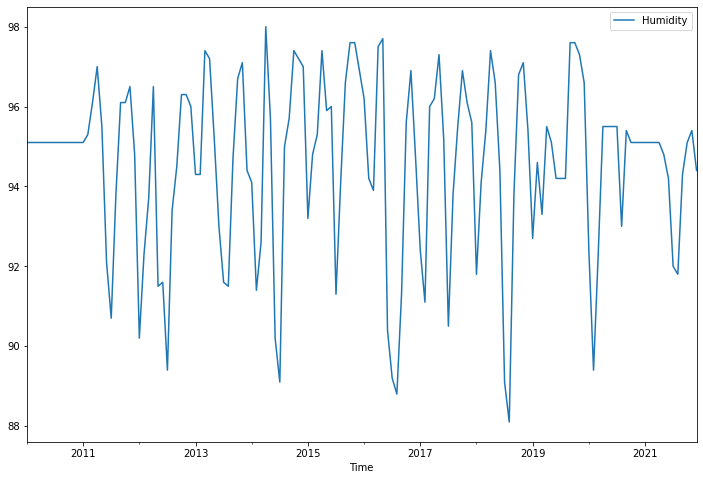

In [16]:
hum.plot(figsize=(12,8))


No trend. But some evidence for seasonality

# Testing For Stationarity

In [17]:
### ADF Test
test_result=adfuller(hum['Humidity'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(hum['Humidity'])


ADF Test Statistic : -4.201182644138367
p-value : 0.0006558695252439342
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [18]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(hum['Humidity'])



KPSS Statistic: 0.04680465613980686
p-value: 0.1
num lags: 12
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(hum['Humidity'].astype(float))
print(pp.summary().as_text())



     Phillips-Perron Test (Z-tau)    
Test Statistic                 -6.145
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Therefore the series is stationary

# ACF and PACF plots

C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


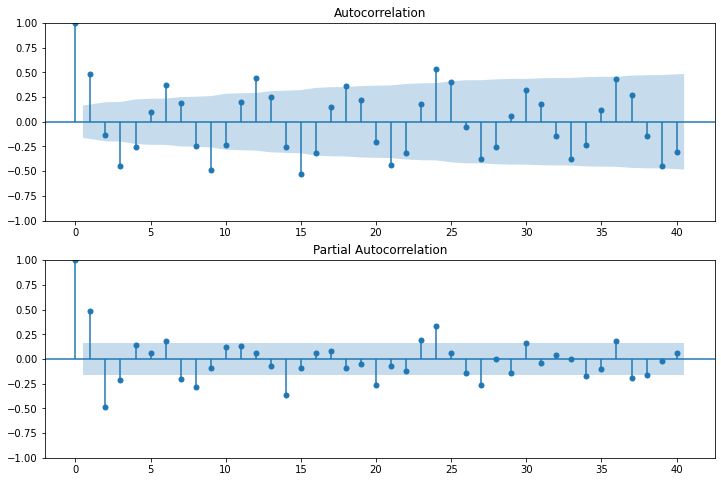

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hum['Humidity'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hum['Humidity'],lags=40,ax=ax2)


According to the PACF and ACF plots, series is likely to follow a MA process. But since we are following step-wise, better to start with p=3,q=3, d=0

In [45]:
arima_model=auto_arima(hum['Humidity'].astype(float),start_p=0,start_q=0,max_p=4,max_q=4,start_P=1,start_Q=1,max_P=3,max_Q=3,m=12,error_action='warn',trace=True,supress_warnings=True,seasonal=True,stepwise=False,random_state=20,n_fits=70,maxiter=70,alpha=0.05)


 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=640.829, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=626.375, Time=0.49 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=601.283, Time=1.42 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=596.801, Time=1.68 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=613.195, Time=1.22 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=607.604, Time=1.75 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=597.910, Time=6.81 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=590.755, Time=9.75 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=646.095, Time=5.39 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=611.072, Time=5.08 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=5.69 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=8.70 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=645.584, Time=1.50 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=inf, Time=5.10 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=inf, Time=8.75 sec
 ARIMA(0,0,1)(0,0,0)[12] i

# Forecast using the model

In [46]:
model=sm.tsa.statespace.SARIMAX(hum["Humidity"].astype('float'),order=(0,0,2),seasonal_order=(3,0,0,12))
results=model.fit()
results.summary()


C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Humidity   No. Observations:                  144
Model:             SARIMAX(0, 0, 2)x(3, 0, [], 12)   Log Likelihood                -400.429
Date:                             Mon, 25 Apr 2022   AIC                            812.859
Time:                                     23:25:34   BIC                            830.678
Sample:                                 01-01-2010   HQIC                           820.099
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7176      0.096      7.465      0.000       0.529       0.906
ma.L2         -0.2803      0.097     -2.898      0.004      -0.470      -0.091
ar.S.L12       0.2515      0.084      2.995      0.003       0.087       0.416
ar.S.L24       0.0141      0.090      0.157      0.875      -0.162       0.191
ar.S.L36       0.7338      0.065     11.355      0.000       0.607       0.860
sigma2         7.0268      1.091      6.443      0.000       4.889       9.164
===================================================================================
Ljung-Box (L1) (Q):                  28.90   Jarque-Bera (JB):                 2.91
Prob(Q):                              0.00   Prob(JB):                         0.23
Heteroskedasticity (H):               0.84   Skew:                             0.08
Prob(H) (two-sided):                  0.53   Kurtosis:                         2.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
hum.tail()

,Humidity,forecast
Time,,
2021-08-01,91.8,94.967777
2021-09-01,94.3,94.967763
2021-10-01,95.1,94.967750
2021-11-01,95.4,94.967736
2021-12-01,94.4,94.967722


In [48]:
beg_dt='2016-01-01'
end_dt='2021-12-01'

<AxesSubplot:xlabel='Time'>

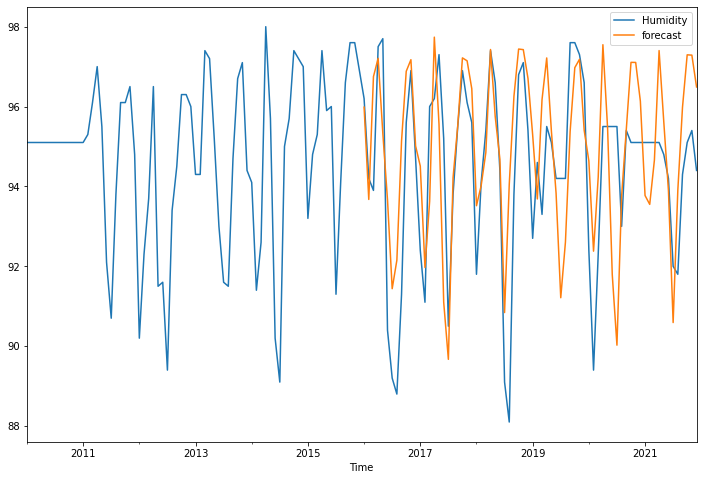

In [49]:
hum['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
hum[['Humidity','forecast']].plot(figsize=(12,8))


In [24]:
hum.tail()

,Humidity,forecast
Time,,
2021-08-01,91.8,93.204466
2021-09-01,94.3,93.075360
2021-10-01,95.1,92.113677
2021-11-01,95.4,90.107728
2021-12-01,94.4,90.346933
